# Comparing the effect of WR winds on the orbital velocity versus the kick velocity

The goal of this notebook is to plot evaluate wether it is the orbital widening caused by winds, or the induced kick velocity caused by the smaller core mass (aslo from winds) is the dominant reason for binaries to unbind. 

### In order to get some analytical grasp on this, I will try to compute V_orb and V_kick at different Z in the following situation

* _Star 1 is going SNe_
* Star 1 is a _naked He star_ (assumed to be binary-stripped)
* We start of with the same initial He-core mass (M_He,i) for star 1 at every metallicity 
    (in reallity, less and less stars make it to this M_He,i at higher Z)

* We assume the stars are on a _circular orbit_
* We assume all _mass is lost only from star 1_, through Z-dependent WR winds
* The specific angular momentum losst through this wind is a _fast isotropic wind_ (i.e., Jeans mode mass loss)


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats

from astropy import units as u
from astropy import constants as const
import seaborn as sns

from matplotlib.lines import Line2D


home_dir = os.path.expanduser("~") 
compas_v = "v02.46.01/"#v02.35.02/"
datar_root =  f"{home_dir}/ceph/CompasOutput/{compas_v}/"

######################################
## PLOT setttings
plt.rc("font", family="serif")
from matplotlib import rc
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30, 20, 25, 30
for obj in ["axes", "xtick", "ytick"]:
    plt.rc(obj, labelsize=SMALL_SIZE)  # controls default text sizes
for obj in ["figure", "axes"]:
    plt.rc(obj, titlesize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize

# We first compute how much mass is lost given a particular wind-mass loss prescription
as a function of initial He-star mass, and metallicity

*** 

## Final mass 

The final total mass is defined as 

$$
M_{tot,f} = M_{tot, i} - dM_{wind}  =  \boxed{ M_{He,i} \cdot (1 + q) - dM_{wind}, }
$$

assuming mass ratio $q \equiv M_2/M_{He,i} $. To estimate how much mass the star looses during the WR phase, we'll use:

$$
\boxed{dM_{wind} \approx  \dot{M}_{WR} \cdot \tau_{He,MS} }
$$

*** 

## He MS lifetime
the nuclear timescale of the He MS is about 10 times shorter than the nuclear timescale for the H-MS:

$$
\tau_{He,MS} \approx \tau_{MS}/10 = 1/10 \cdot 10^{10} \frac{M_{ZAMS}}{M_{\odot}} \frac{L_{\odot}}{L} yr =  2.9 * 10^{9} \frac{M_{He,i}}{M_{\odot}} \frac{L_{\odot}}{L} yr
$$
Where we've used that $M_{He,i} \approx 0.35 M_{ZAMS}$

*** 
## He,MS luminosity

* From Hurley + 200 we take formulas for the Luminosity of the He MS:

eq 80 at $\tau = 1$ (i.e., terminal age main sequence)

$$
L_{THeMS} = L_{ZHe} (1 + 0.45 + \alpha)
$$

eq. 77:
$$
 L_{ZHe}  = \frac{15262 \cdot  M_{He,i}^{10.25}}{M_{He,i}^{9} + 29.54 \cdot M_{He,i}^{7.5} + 31.18 M_{He,i}^{6} + 0.0469}
$$


eq. 82:
$$
\alpha = max(0,0.85 - 0.08 M_{He,i})
$$


* Alternatively the mass luminosity relation from Grafener (2011)

$$
\log(L/L_{\odot}) = F1 + F2 \cdot \log_{10}(M) + F3 \cdot (\log_{10}(M))^2
$$



In [2]:
###########################################
# Computing the luminosity of a naked helium star
###########################################
# Hurley 2000 : the terminal age He-MS luminosity for a stripped star following Hurley
def L_THEMS(M_hei):
    """
    Hurley 2000
    """
    # eq. 82
    alpha = np.maximum(0, 0.85 - 0.08 * M_hei)

    # eq. 77
    L_ZHe = (15262 * M_hei**10.25) / (
        M_hei**9 + 29.54 * M_hei**7.5 + 31.18 * M_hei**6 + 0.0469
    )

    # L_THEMS eq. 80
    L_THEMS = L_ZHe * (1 + 0.45 + alpha)

    return L_THEMS  # L/Lsun


def LM_Grafener2011(M, F1=3.017, F2=2.446, F3=-0.306):
    """Mass Luminosity relation for H-free stars
    eq 10 in
    https://arxiv.org/pdf/1106.5361.pdf
    """
    logL_Lsun = F1 + F2 * np.log10(M) + F3 * np.log10(M) ** 2
    return 10**logL_Lsun


###########################################
# Mass lumminosity relation for naked He stars
L = LM_Grafener2011(22)  # L/Lsun
print("Using Grafener (2011) logL/Lsun = ", np.log10(L))


L = L_THEMS(22)  # L/Lsun
print("Using Hurely (2000) logL/Lsun = ", np.log10(L))

Using Grafener (2011) logL/Lsun =  5.749123689171438
Using Hurely (2000) logL/Lsun =  5.9126879550772




## WR wind mass loss

We consider a few WR wind-mass loss cases:

#### 1) Z-scaled version of the WR winds from Hamann & Koesterke (1998):
$$
\dot{M}_{WR} = f_{WR} \times 10^{-13} \left( \frac{L}{L_{\odot}} \right)^{1.5} \left( \frac{Z}{Z_{\odot}} \right)^{0.86} \, M_{\odot} \, yr^{-1}
$$
By default $f_{WR} = 1$


#### 2a) Vink (2017) for low luminosity WR stars:
$$
\boxed{ \log \dot{M}_{Vink2017} = -13.3 + 1.36 \log L + 0.61 \log_{10}\left(\frac{Z}{Z_{\text{sun}}}\right) }
$$

#### 2b) Sander & Vink for high luminosity WR stars:
eq. 14 from https://arxiv.org/abs/2009.01849
$$
\boxed{ \dot{M}_{SV2020} = \dot{M}_{10} \left(\log\frac{L}{L_{0}}\right)^{\alpha} \left(\frac{L}{10L_{0}}\right)^{\frac{3}{4}} }
$$

(not you get a bunch of log10(log10) if you calculate $\log_{10}\dot{M}$ )

with $\alpha$ defined in eq. 18:
$$
\alpha = 0.32(\pm0.08) \cdot \log\left(\frac{Z}{Z_{\odot}}\right) + 1.40(\pm0.07) 
$$

$\log\left(L_{0}/L\right)$ in eq. 19:
$$
\log\left(L_{0}/L\right) = -0.87(\pm0.02) \cdot \log\left(\frac{Z}{Z_{\odot}}\right) + 5.06(\pm0.02) \quad (19)
$$

and $\log\left(\frac{\dot{M}_{10}}{M_{\odot}\text{yr}^{-1}}\right)$ in eq. 20:
$$
\log\left(\frac{\dot{M}_{10}}{M_{\odot}\text{yr}^{-1}}\right) = -0.75(\pm0.02) \cdot \log\left(\frac{Z}{Z_{\odot}}\right) - 4.06(\pm0.02)
$$


Finally Sander et al. 2023 (https://www.aanda.org/articles/aa/full_html/2023/02/aa45110-22/aa45110-22.html) provide an additional temperature-dependent correction in their eq. 18:

$$
\log\left(\frac{\dot{M}}{M_{\odot}\text{yr}^{-1}}\right) = \log\left(\frac{\dot{M}_{SV2020}}{M_{\odot}\text{yr}^{-1}}\right) - 6 \log\left(\frac{T_{\text{eff}}}{141 \text{kK}}\right)
$$

That we apply whenever $T_{\text{eff}} > 10^5 \text{K}$



#### 2c) Combined WR wind mass loss from Sander & Vink(2020) +  Vink (2017) 
$$
\boxed{ \dot{M}_\mathrm{WR} = \mathrm{max}(\dot{M}_\mathrm{Vink2017}, \dot{M}_\mathrm{SV2023}) }
$$




HamannKoesterke1998 at 1e5Lsun =  -5.5
Vink2017 at Zsun and 1e4Lsun =  -7.86
SanderVink2020 at Zsun and 2e5Lsun -5.494327973120155


/tmp/ipykernel_919732/1357242206.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


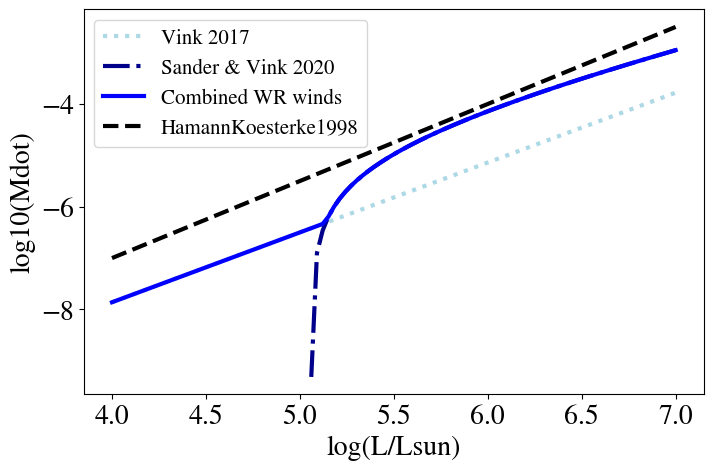

In [104]:
###########################################
# Different wind-mass-loss prescriptions
###########################################
# Hamman & Koesterke 1998 (old default COMPAS)
def HamannKoesterke1998(L, Z, Zsun = 0.014, fWR=1.0):
    """
    Eq 9 from Belczynski 2010
    http://arxiv.org/abs/0904.2784
    Should be based on Hamann & Koesterke 1998: (based on 62 WN stars)
    https://ui.adsabs.harvard.edu/abs/1998A&A...335.1003H/abstract
    But I never actually found this equation in here???
    """
    Mdot = fWR * 1e-13 * (L / const.L_sun) ** 1.5 * (Z / Zsun) ** 0.86
    return np.log10(Mdot) # log10 Msun yr^-1

print('HamannKoesterke1998 at 1e5Lsun = ', HamannKoesterke1998(1e5*const.L_sun, 0.014, fWR=1.0) )

##################
# Vink 2017
def Vink2017(L, Z, Zsun=0.014):
    """
    Equation 1 in Vink 2017
    Theoretical mass loss rates for He stars in the range 2-20 Msun
    https://arxiv.org/abs/1710.02010
    Derived for Z/Zsun = 1 − 1e−2 and mass range 2 - 60 Msun
    """
    logL = np.log10(L / const.L_sun)
    logMdot = -13.3 + 1.36 * logL + 0.61 * np.log10(Z / Zsun)

    return logMdot

print('Vink2017 at Zsun and 1e4Lsun = ', Vink2017(1e4*const.L_sun, 0.014, Zsun=0.014) )

# Sander & Vink 2020
def SanderVink2020(L, Z, Zsun = 0.014):
    """
    Eq 13 and 18-20 in Andreas & Vink 2020
    https://arxiv.org/abs/2009.01849
    
    + Temperature correction from Sander et al. 2023
    https://www.aanda.org/articles/aa/full_html/2023/02/aa45110-22/aa45110-22.html

    !! Takes L in L/Lsun, i.e. 2e5,  (many values return NAN)

    """
    # Mass lumminosity relation for nakeed He stars
    # L = 170761.47525570545 #LM_Grafener2011(M, F1 = 3.017, F2=2.446, F3 = -0.306) #L/Lsun
    # print('for M = ', M, 'L = ', L)
    # general wind mass loss prescription
    alpha      = 0.32 * np.log10(Z/Zsun) + 1.4
    logL0_Lsun = -0.87*np.log10(Z/Zsun) + 5.06 
    logMdot10  = -0.75 * np.log10(Z/Zsun) - 4.06 
    
    log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10

    # Temperature correction to the SanderVink2020 prescription # I dont have Teff for now
    # if Teff > 1e5:
        # M_SV2023 = M_SV2020 - 6 * np.log10( Teff/(141 *1e3) )
    logMdot = log_Mdot2020 #- 6 * np.log10(1e5/(141 *1e3) )

    return  logMdot # log10 Msun yr^-1

print('SanderVink2020 at Zsun and 2e5Lsun', SanderVink2020(2e5, 0.014, Zsun=0.014) )


# Combined WR winds for low and high L combining Vink 2017 + Sander & Vink 2020
def WRwind_SV(L, Z, Zsun=0.014):
    """
    Combined WR wind prescription for low and high luminosity
    """
    M_vink2017 = Vink2017(L*const.L_sun, Z, Zsun=Zsun) #log10(Mdot)
    # print('M_vink2017',M_vink2017)
    M_SV2020 = SanderVink2020(L, Z, Zsun=Zsun) #log10(Mdot)
    # print('M_SV2020', M_SV2020)

    # Replace NaN values with small number
    M_vink2017 = np.where(np.isnan(M_vink2017), -99, M_vink2017)
    M_SV2020 = np.where(np.isnan(M_SV2020), -99, M_SV2020)

    return np.maximum(M_vink2017, M_SV2020) #log10(Mdot)

# WRwind_SV(2e5, 0.014, Zsun=0.014)
WRwind_SV(np.linspace(10**4, 10**7), 0.014, Zsun=0.014)


############################################
# Check that our prescriptions are working
fig, ax = plt.subplots(figsize=(8, 5))
log_L_Lsun = np.linspace(4, 7, num = 100) #log10(L/Lsun)
metallicity = 0.014
plt.plot(log_L_Lsun, Vink2017(10**log_L_Lsun*const.L_sun, metallicity), label = 'Vink 2017', lw = 3, ls = ':', c = 'lightblue')
plt.plot(log_L_Lsun, SanderVink2020(10**log_L_Lsun, metallicity) , label = 'Sander & Vink 2020', lw = 3,ls = '-.', c = 'darkblue')
plt.plot(log_L_Lsun, WRwind_SV(10**log_L_Lsun, metallicity), label = 'Combined WR winds', lw = 3,ls = '-', c = 'blue')

plt.plot(log_L_Lsun, HamannKoesterke1998(10**log_L_Lsun*const.L_sun, metallicity), label = 'HamannKoesterke1998', lw = 3,ls = '--', c = 'black')
plt.xlabel('log(L/Lsun)')
plt.ylabel('log10(Mdot)')
plt.legend( loc='upper left', fontsize = 15)#bbox_to_anchor=(1.05, 1),
plt.show()  


## Final mass 

The final total mass is defined as 

$$
M_{tot,f} = M_{tot, i} - dM_{wind}  =  \boxed{ M_{He,i} \cdot (1 + q) - dM_{wind}, }
$$

assuming mass ratio $q \equiv M_2/M_{He,i} $. To estimate how much mass the star looses during the WR phase, we'll use:

$$
\boxed{dM_{wind} \approx  \dot{M}_{WR} \cdot \tau_{He,MS} }
$$

*** 

/tmp/ipykernel_919732/1357242206.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


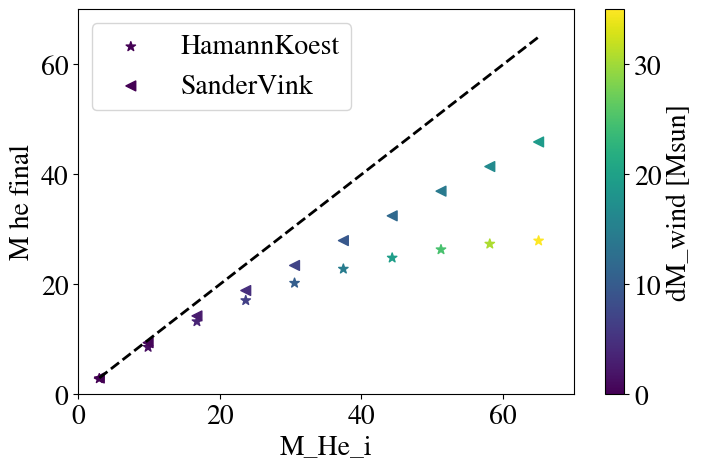

In [105]:
###########################################
# Computing the mass losst 
###########################################
# estimate of total mass lost from WR-like winds during the He-MS phase
from cProfile import label


def dM_wind(M_He_i, Z, L_hestar = 'Hurley', WR_wind = 'SanderVink'):
    """
    !!! Make sure to provide:
    M_he in Msun
    Z         ----- Metallicity   
    L_hestar  ----- What M-L relation to use ['Hurley', Grafener2011]
    WR_wind   ----- What WR wind mass loss to use [HamannKoest, 'SanderVink']
    """

    # Compute He star luminosity from the mass
    if L_hestar == 'Hurley':
        L_Lsun = L_THEMS(M_He_i)    # 10**5.4 #/const.L_sun.value # Lsun  (taken from Spera + 2019 SEVN paper, fig 1)
    if L_hestar == 'Grafener2011':
        L_Lsun = LM_Grafener2011(M_He_i)
    # print( 'log10 L_Lsun', np.log10(L_Lsun), '\n')

    # Calculate He main sequence time
    tau_He_MS = 2.9e9 * (M_He_i) * L_Lsun**-1 #(L_sun/L)  # in years
    # print('tau_He_MS', tau_He_MS*1e-6, 'Myr \n')

    if WR_wind == 'SanderVink':
        dotM_WR = 10**WRwind_SV(L_Lsun, Z, Zsun = 0.014)
    elif WR_wind == 'HamannKoest':
        dotM_WR = 10**HamannKoesterke1998(L_Lsun*const.L_sun, Z, fWR = 1.).value
    else:
        raise ValueError('WR wind prescription not recognized')

    # print('log $\dot{M}_{WR}$', np.log10(dotM_WR) )

    dM_wind = tau_He_MS * dotM_WR

    return dM_wind # Msun

##########################
## Test the mass loss
masses = np.linspace(3, 65, 10)
dM_HamannKoest =  dM_wind(masses, 0.014, L_hestar = 'Hurley', WR_wind = 'HamannKoest') 
dM_SanderVink  =  dM_wind(masses, 0.014, L_hestar = 'Hurley', WR_wind = 'SanderVink') 

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(masses, masses - dM_HamannKoest, label = 'HamannKoest', marker = '*',s = 50, c = dM_HamannKoest, vmin = 0, vmax = 35)
plt.scatter(masses, masses - dM_SanderVink, label = 'SanderVink', marker = '<',  s = 50, c = dM_SanderVink, vmin = 0, vmax = 35)
plt.colorbar(label  = 'dM_wind [Msun]')

plt.plot(masses, masses, c = 'black', ls = '--', lw = 2)

plt.xlabel('M_He_i')    
plt.ylabel('M he final')   
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.legend()
# plt.ylabel('final He core mass')   
plt.show()

# Computing the orbital Velocity, v_orb

## Circular orbital velocity

$$
\boxed{v_{orb} = \sqrt{\frac{G M_{tot,f}}{a_f} }}
$$


## Fast or Jeans mode mass loss
We know that 

$$
a(M_1 + M_2) = const
$$

(see e.g., Pols lecture notes for full derivation in this case)
This means that 
$$
\frac{d a M_{tot}}{dt} = 0 \rightarrow   \frac{da}{dt}M_{tot} + a \frac{dM_{tot}}{dt} = 0 \rightarrow \frac{da}{dt a} = \frac{-dM_{tot}}{dt M_{tot}}
$$

integrating this
$$
\int_{a_i}^{a_f} \frac{da}{dt a} dt = \int_{M_{tot,i}}^{M_{tot,f}}\frac{-dM_{tot}}{dt M_{tot}} dt = \ln(\frac{a_f}{a_i}) = \ln(\frac{M_{tot,i}}{M_{tot,f}})
$$

or

$$
\boxed{a_f = a_i \frac{M_{tot,i}}{M_{tot,f}}}
$$



In [106]:
# Circular orbital velocity
def v_orb(M_tot_f, a_f):
    """
    a_f in Rsun
    M_tot_f in Msun
    """
    G_new_units = const.G.to(u.Rsun**3 / u.Msun / u.yr**2)

    v_orb = np.sqrt(G_new_units * M_tot_f / a_f)

    return v_orb.to(u.km / u.s)

In [107]:
M_He_i = 10  # Msun

# It's more natural to pick q_zams: q_ZAMS = 0.35 * q
q_zams = 1
q = q_zams / 0.35

m2 = q * M_He_i
print("m2", m2)

Z = 0.014

# initial separation in Rsun
a_i = 500  # Rsun

Mtot_initial = M_He_i * (1 + q)
print("Mtot_initial", Mtot_initial)

# Estimate wind mass lost
wind_mass_loss = dM_wind(M_He_i, Z)
print("wind_mass_loss", wind_mass_loss)

# Calculate final He-core mass post wind mass loss
Mtotfinal = M_He_i * (1 + q) - wind_mass_loss
print("Mtotfinal", Mtotfinal)

print("Mtot_initial / Mtotfinal", (Mtot_initial / Mtotfinal))

# Final separation due to wind mass loss widening
final_separation =  a_i * (Mtot_initial / Mtotfinal)
# final_separation = a_f(a_i, Mtot_initial, Mtotfinal)
print("final_separation", final_separation)

orbital_vel = v_orb(Mtotfinal * u.Msun, final_separation * u.Rsun)
print("orbital_vel", orbital_vel)

m2 28.571428571428573
Mtot_initial 38.57142857142857
wind_mass_loss 0.5017734351858728
Mtotfinal 38.069655136242694
Mtot_initial / Mtotfinal 1.0131804040091812
final_separation 506.5902020045906
orbital_vel 119.7308026009603 km / s


# Computing the kick velocity v_kick

$$
v_{kick} = v_{NS,kick} (1-f_{fb})
$$
Where $v_{NS,kick}$ is a kick drawn from a Maxwell-Boltzmann distribution with $\sigma_{kick} = 265 km/s$

The fallback fraction $f_{fb}$ is defined in Fryer +2012:

$$
f_{fb} = a_2 M_{CO} + b_2 
$$


$$
f_{fb} = 
\begin{cases} 
a_2 M_{CO} + b_2 &  3.5 M_{\odot} \leq M_{CO} < 11M_{\odot} \\
1.0 &  M_{CO} \geq 11 M_{\odot} \\
\end{cases}
$$

$$
a_2 = 0.133 - \left(0.093/M - M_{proto} \right)
$$

$$
b_2 = -11 a_2 + 1
$$

and with 

$$
M_{proto} = 
\begin{cases} 
1.2 &   & M_{CO} < 3.5M_{\odot} \\
1.3 &  3.5 M_{\odot} \leq & M_{CO} < 6 M_{\odot} \\
1.4 &  6 M_{\odot} \leq & M_{CO} < 11 M_{\odot} \\
1.6 &   & M_{CO} \geq 11 M_{\odot} \\
\end{cases}
$$

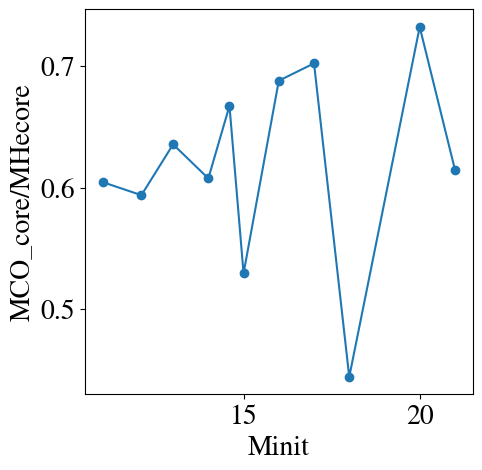

In [108]:
# To estimate what fraction of the He-core is in the CO-core
# From Eva's Table 1 (Different to the core)
# https://arxiv.org/abs/2102.05036

Minit = np.array([11.0, 12.1, 13.0, 14.0, 14.6, 15.0, 16.0, 17.0, 18.0, 20.0, 21.0])
MCO_core = np.array([1.88, 2.09, 2.46, 2.57, 2.99, 2.44, 3.42, 3.73, 2.49, 4.60, 4.07])
MHecore = np.array([3.11, 3.52, 3.87, 4.23, 4.48, 4.61, 4.97, 5.31, 5.61, 6.28, 6.62])

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(Minit, MCO_core / MHecore, label="binary stripped", marker="o")
plt.xlabel("Minit")
plt.ylabel("MCO_core/MHecore")
plt.show()

In [109]:
def M_proto(M_CO):
    Mproto = np.zeros_like(M_CO)

    mask1 = M_CO < 3.5
    Mproto[mask1] = 1.2

    mask2 = np.logical_and(3.5 <= M_CO, M_CO < 6)
    Mproto[mask2] = 1.3

    mask3 = np.logical_and(6 <= M_CO, M_CO < 11)
    Mproto[mask3] = 1.4

    mask4 = M_CO >= 11
    Mproto[mask4] = 1.6

    return Mproto


def f_fb(M_he_core):
    """
    Compute the fallback fraction based on the CO core mass
    prescription form Fryer + 2012
    We only use this to compute the reweighting of the kick (not the remnant mass)
    Args:
        M_he_core in Msun
    Returns:
        fallback fraction
    """
    # Assume about 60% of He core forms CO core
    M_CO = 0.6 * M_he_core
    # print('M_CO', M_CO)

    # M_proto
    proto_core_mass = M_proto(M_CO)
    # print('proto_core_mass', proto_core_mass)

    a2 = 0.133 - (0.093 / (M_he_core - proto_core_mass))
    b2 = -11 * a2 + 1

    # Create an array to store the results
    fallback_fraction = np.empty_like(M_CO)
    
    # if 3.5 <= M_CO < 11
    mask1 = np.logical_and((3.5 <= M_CO) , (M_CO < 11) )
    fallback_fraction[mask1] = a2[mask1] * M_CO[mask1] + b2[mask1]
    
    # if M_CO >= 11
    mask2 = M_CO >= 11
    fallback_fraction[mask2] = 1.0
    
    # In this case there is no fallback --> full kicks
    mask3 = ~mask1 & ~mask2
    fallback_fraction[mask3] = 0

    return fallback_fraction

# We assume its a stripped star with mass M = M_He_i
fallback_fraction = f_fb(np.array([20]) )
print("f_fb", fallback_fraction)

M_He_f = np.linspace(3.5, 20, 10)
fallback_fraction = f_fb(M_He_f)
print(fallback_fraction)


f_fb [1.]
[0.         0.         0.21511023 0.32283636 0.44586396 0.57586509
 0.71042824 0.84787321 0.98725467 1.        ]


In [186]:
def get_v_kicks(sigma_kick = 265, fallback_fraction = 0.0):
    ''''
    draw a natal-kick from a Maxwell-Boltzmann distribution
    sigma_kick = 265  # km/s

    '''
    scale = sigma_kick  # / np.sqrt(2)

    # Draw a single value of Maxwell-Boltzmann distribution
    # scale = a in https://mathworld.wolfram.com/MaxwellDistribution.html
    v_kicks = stats.maxwell.rvs(scale=scale, size=1000)  # get a 100 values at once

    # fallback reduced kicks
    fallback_fraction = fallback_fraction[:, np.newaxis] # to make the outcome 2D
    v_kicks_reduced = v_kicks * (1 - fallback_fraction)

    # Get the 10th, 50th and 90th percentile (along the 1000 draws)
    v_kick_10 = np.percentile(v_kicks_reduced, 10, axis =1)
    v_kick_50 = np.percentile(v_kicks_reduced, 50, axis =1)
    v_kick_90 = np.percentile(v_kicks_reduced, 90, axis =1)

    # print("v_kick_10", v_kick_10, "v_kick_50", v_kick_50, "v_kick_90", v_kick_90)

    return v_kicks_reduced, v_kick_10, v_kick_50, v_kick_90

v_kicks_reduced, v_kick_10, v_kick_50, v_kick_90 = get_v_kicks(sigma_kick = 265, fallback_fraction = np.linspace(0, 1, 5))

In [187]:
def get_v_orb_and_f_fb(M_He_i=20, q_zams=0.7, a_i=1000, WR_wind_presc = 'HamannKoest',
                       z_list=np.logspace(-4, np.log10(0.03), 100)): 
    """
    M_He_i: initial He core mass in Msun
    q_zams: initial mass ratio
    a_i: initial separation in Rsun
    z_list: list of metallicities
    WR_wind_presc   ----- What WR wind mass loss to use [HamannKoest, 'SanderVink']
    """
    # print('z_list', z_list)
    q = q_zams / 0.35

    # Calculate initial total mass of system
    Mtot_initial = M_He_i * (1 + q)
    # print("Mtot_initial", Mtot_initial)

    wind_mass_loss = dM_wind(M_He_i, z_list, L_hestar = 'Hurley', WR_wind = WR_wind_presc)
    # print("wind_mass_loss", wind_mass_loss)

    # Final He core and total mass post wind mass loss
    M_He_f = M_He_i - wind_mass_loss
    Mtotfinal = Mtot_initial - wind_mass_loss
    # print('M_He_f', M_He_f, 'Mtotfinal', Mtotfinal)

    # Final separation due to wind mass loss widening
    final_separation =  a_i * (Mtot_initial / Mtotfinal)

    orbital_vel = v_orb(Mtotfinal * u.Msun, final_separation * u.Rsun)

    # received kick as a function of Z
    fallback_fraction = f_fb(M_He_f) # np.array([f_fb(m) for m in M_He_f])  # We assume its a stripped star with mass M = M_He (post wind mass loss)

    return z_list, q, orbital_vel, fallback_fraction, M_He_f, wind_mass_loss

In [188]:
z_list, q, orbital_vel, fallback_fraction, M_He_f, wind_mass_loss = get_v_orb_and_f_fb(M_He_i=15, q_zams=0.5, a_i=500)

print('z_list',z_list)
print('q',q)
print('orbital_vel', orbital_vel)
print('fallback_fraction', fallback_fraction)

z_list [0.0001     0.00010593 0.00011221 0.00011887 0.00012592 0.00013339
 0.0001413  0.00014968 0.00015855 0.00016795 0.00017792 0.00018847
 0.00019964 0.00021148 0.00022403 0.00023731 0.00025139 0.0002663
 0.00028209 0.00029882 0.00031654 0.00033531 0.0003552  0.00037626
 0.00039858 0.00042222 0.00044726 0.00047378 0.00050188 0.00053164
 0.00056317 0.00059657 0.00063195 0.00066943 0.00070913 0.00075119
 0.00079574 0.00084293 0.00089292 0.00094588 0.00100198 0.0010614
 0.00112435 0.00119103 0.00126166 0.00133649 0.00141575 0.00149971
 0.00158865 0.00168287 0.00178267 0.00188839 0.00200039 0.00211902
 0.00224469 0.00237782 0.00251884 0.00266822 0.00282646 0.00299409
 0.00317165 0.00335975 0.003559   0.00377007 0.00399366 0.00423051
 0.0044814  0.00474718 0.00502872 0.00532695 0.00564287 0.00597752
 0.00633203 0.00670755 0.00710535 0.00752674 0.00797312 0.00844598
 0.00894687 0.00947748 0.01003955 0.01063495 0.01126567 0.01193379
 0.01264154 0.01339125 0.01418544 0.01502672 0.01591789 0

/tmp/ipykernel_919732/1357242206.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


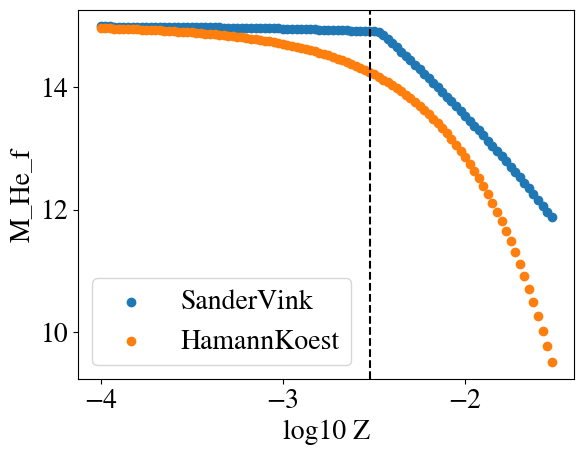

In [189]:
z_list= np.logspace(-4, np.log10(0.03), 100)  

# Sander & Vink
z_list, q, orbital_vel, fallback_fraction, M_He_f, wind_mass_loss = get_v_orb_and_f_fb(M_He_i=15, q_zams=0.5, a_i=500, WR_wind_presc = 'SanderVink')
plt.scatter(np.log10(z_list), M_He_f, label = 'SanderVink')

# Sander & Vink
z_list, q, orbital_vel, fallback_fraction, M_He_f, wind_mass_loss = get_v_orb_and_f_fb(M_He_i=15, q_zams=0.5, a_i=500, WR_wind_presc = 'HamannKoest')
plt.scatter(np.log10(z_list), M_He_f, label = 'HamannKoest')

plt.axvline(np.log10(3e-3), c = 'black', ls = '--')
plt.xlabel('log10 Z')
plt.ylabel('M_He_f')
# plt.ylim(0,55)
plt.legend()
plt.show()

/tmp/ipykernel_919732/1357242206.py:54: RuntimeWarning: invalid value encountered in log10
  log_Mdot2020   = alpha * np.log10(np.log10(L) - logL0_Lsun) + 0.75 * (np.log10(L) - logL0_Lsun - 1.0) + logMdot10


v_kicks_reduced [[ 50.71956934  64.92357706  45.33660519 ...  34.60006684  35.26764195
   63.53559751]
 [ 50.7383353   64.94759843  45.35337949 ...  34.61286867  35.28069079
   63.55910533]
 [ 50.75777245  64.97247894  45.37075373 ...  34.62612838  35.29420633
   63.58345394]
 ...
 [187.06745529 239.45566783 167.21363124 ... 127.6143812  130.07657834
  234.33642479]
 [190.99969044 244.48912484 170.72853081 ... 130.29688819 132.81084172
  239.26227319]
 [194.97816276 249.58176773 174.28476032 ... 133.01093742 135.57725593
  244.24604217]] [21.27912553 21.28699869 21.29515344 21.30359985 21.31234836 21.32140976
 21.33079524 21.3405164  21.35058523 21.36101418 21.37181612 21.38300438
 21.39459279 21.40659564 21.41902777 21.43190452 21.44524179 21.45905604
 21.47336434 21.48818435 21.50353437 21.51943334 21.53590089 21.55295736
 21.5706238  21.58892202 21.60787461 21.62750496 21.64783731 21.66889674
 21.69070927 21.7133018  21.73670223 21.76093944 21.78604334 21.8120449
 21.83897623 21.866

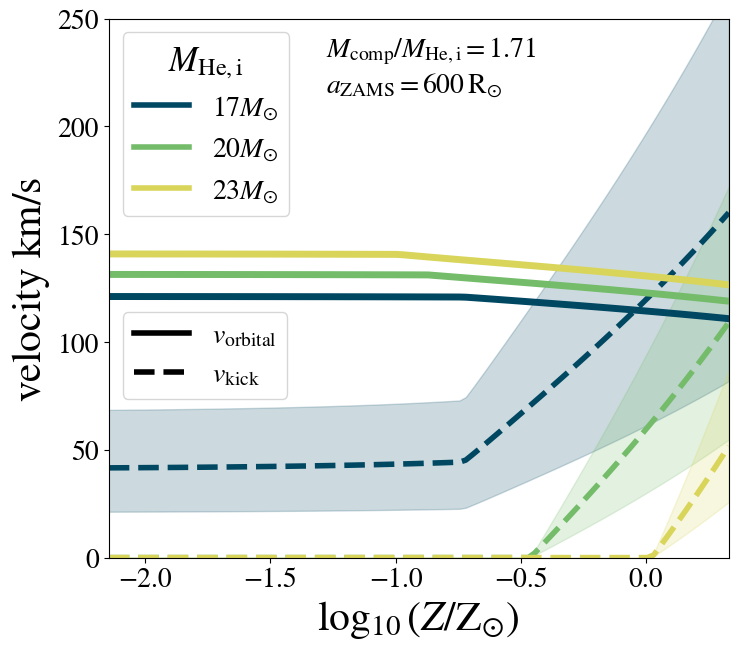

In [202]:
####################################
# Define a few parameters
# colors = sns.cubehelix_palette(start=2, rot=0.2, dark=0.1, light=.7, reverse=True, n_colors = 3)
colors = sns.color_palette("viridis", 3)
# colors = ['#5EA29C',  '#ffc000', '#E44D4D']
colors = ["#004762", "#74BC6A", "#D9D55A"]
initial_helium_masses = [17, 20, 23]
# initial_helium_masses = [18,  22, 35]

zams_mass_ratio = 0.6
zams_separation = 600  # Rsun
prescription = "SanderVink" # HamannKoest, SanderVink
####################################
fig, ax = plt.subplots(figsize=(8, 7))
for i, he_mass in enumerate(initial_helium_masses):
    z_list, q, orbital_vel, fallback_fraction, M_He_f, wind_mass_loss = get_v_orb_and_f_fb(M_He_i=he_mass, q_zams=zams_mass_ratio, 
                                                                                           a_i=zams_separation, WR_wind_presc = prescription)

    ####################
    # Orbital velocity as a funciton of Z
    plt.plot(np.log10(z_list/0.014),orbital_vel, 
             lw=5,color=colors[i],ls="-", label="$v_{\mathrm{orbital}}$ mhe = " + str(he_mass) + "Msun")

    ####################
    # Kick velocities reweighted by f_fb
    # v_kicks, v_kick_10, v_kick_50, v_kick_90 = get_v_kicks(sigma_kick = 265, fallback_fraction = fallback_fraction)
    v_kicks_reduced, v_kick_10, v_kick_50, v_kick_90 = get_v_kicks(sigma_kick = 265, fallback_fraction = fallback_fraction)

    print('v_kicks_reduced',v_kicks_reduced, v_kick_10, v_kick_50, v_kick_90)

    print('(1 - fallback_fraction)', (1 - fallback_fraction))
    plt.plot(np.log10(z_list/0.014), v_kick_50, #v_kick_50 * (1 - fallback_fraction), 
             lw=4, ls="--", color=colors[i], label="$v_{\mathrm{kick}}$ mhe = " + str(he_mass) + "Msun")
    plt.fill_between(np.log10(z_list/0.014), y1=v_kick_10, y2=v_kick_90,
                     color=colors[i],alpha=0.2,label=None)
                    #  y1=v_kick_10 * (1 - fallback_fraction), y2=v_kick_90 * (1 - fallback_fraction),
        
# Annotate the used q_zams and a_zams
plt.text(0.35,0.97,
    f"$M_{{\mathrm{{comp}}}}/M_{{\mathrm{{He,i}}}}= {np.round(q,2)}$\n$a_{{\mathrm{{ZAMS}}}} = {zams_separation}$"
    + "$\, \mathrm{R_{\odot}}$",
    ha="left",va="top", transform=ax.transAxes,fontsize=20,)

# Legend for the He masses
legend_elements1 = [Line2D([0], [0], color=colors[i], lw=4, label=f"{he_mass}" + "$M_{\odot}$")
    for i, he_mass in enumerate(initial_helium_masses)]
legend1 = ax.legend(handles=legend_elements1, loc="upper left", title="$M_{\mathrm{He,i}}$")

# Legend for the orbital and kick velocities
legend_elements2 = [
    Line2D([0], [0], color="k", lw=4, ls="-", label="$v_{\mathrm{orbital}}$"),
    Line2D([0], [0], color="k", lw=4, ls="--", label="$v_{\mathrm{kick}}$"),
]
legend2 = plt.legend(handles=legend_elements2, loc="center left", bbox_to_anchor=(0, 0.375), fontsize=20)

ax.add_artist(legend1)

plt.xlabel("$\log_{10}(Z/\mathrm{Z}_{\odot}$)", fontsize=30)
plt.ylabel("$\mathrm{velocity \ km/s}$", fontsize=30)
plt.ylim(0, 250)
plt.xlim(np.log10(1e-4 / 0.014), np.log10(0.03 / 0.014))
plt.savefig(f"../plots/{compas_v}/v_kick_v_orb_{prescription}.pdf", bbox_inches="tight")
plt.show()